## Accelerated SGD

In [ ]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from typing import Callable

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=170, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

plt.style.use('dark_background')
set_seed(42)

In [ ]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

bs = 1024
# from previous nb
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# create Multiclass accuracy metrics CB
metrics = 
# create ActivationStats for GeneralRelu
astats = 
# callbacks for device, metrics, progress and activation stats
cbs = 
# activation function general relu with leak 0.1 and sub 0.4
act_gr = 
# weight initialization function with leaky 0.1
iw = 
# separate callbacks for learning rate finder (device and lrfinder)
lrf_cbs = 

## Optimizers

### SGD

Optimizers generally have two key methods: optimizer step and regularizer step

In [ ]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        # import ipdb; ipdb.set_trace()
        # cast params to list this is important to make mutable
        
        # store attrs and set self.i to zero to track
        
        
    def step(self):
        # with no grad for each parameter perform teg step and opt step
        
        # add to counter
        
    
    # opt step is a simple update of parameter
    def opt_step(self, p): 
    def reg_step(self, p):
        # weight = weight - lr*wd*weight
        # weight = weight*(1-lr*wd)
        # accout for weight decay if it is not none. See below
        
        
    def zero_grad(self):
        # if use `.data` can skip `torch.no_grad`
        

In [ ]:
set_seed(42)
# get model with BN and weights initialization
model = 
# TrainLearner
learn = 

accuracy,loss,epoch,train
0.707,0.897,0,train
0.776,0.620,0,eval
0.806,0.545,1,train
0.811,0.526,1,eval
0.830,0.476,2,train
0.826,0.483,2,eval


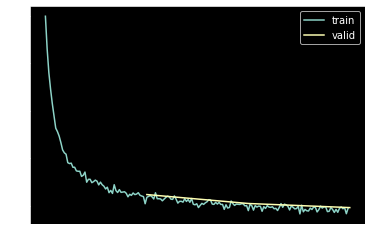

In [ ]:
learn.fit(3)

Consider the difference between weight decay and L2 regularization:
```python
weight -= lr*wd*weight
```
...vs...
```python
weight.grad += wd*weight
```

The resoning: usual gradient update is:`weight -= lr * weight.grad`. In regularization we add `weight**2` to the loss which is equivalent to updating the weight gradient by adding weight decay times the weight: `weight.grad += wd*weight`. So we can rewrite the whole reg update like this: `weight -= lr*wd*weight` -> `weight = weight*(1-lr*wd)`

### Momentum 

Let's see what momentum looks like in practice.

In [ ]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

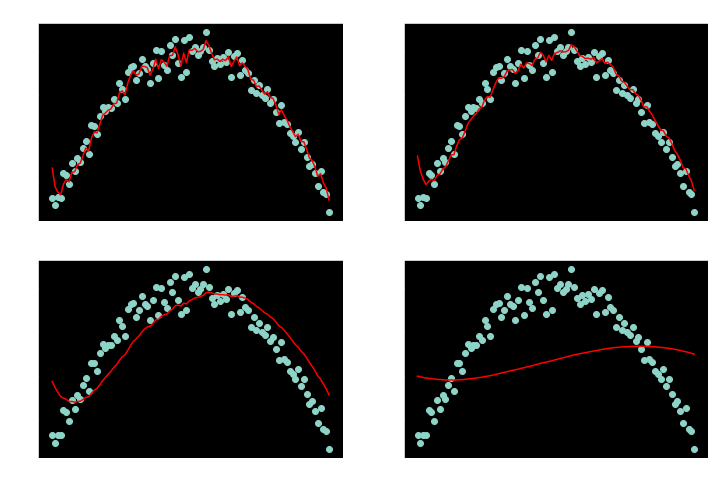

In [ ]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
# recreate plot below

In [ ]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        # super init and save mom
        
        
    def opt_step(self, p):
        # if there is no `grad_avg`, create it with the shape of grad
      
        # calculate moving grad_avg
       
        # perform the parameter update
       

Because Momentum smoothes out the loss function, it allows us to increase the learning rate.

In [ ]:
set_seed(42)
# get model
model = 
# Train Learner with lr = 1.5 and opt_func Momentum
learn = 

accuracy,loss,epoch,train
0.787,0.592,0,train
0.850,0.413,0,eval
0.870,0.356,1,train
0.851,0.391,1,eval
0.884,0.315,2,train
0.868,0.357,2,eval


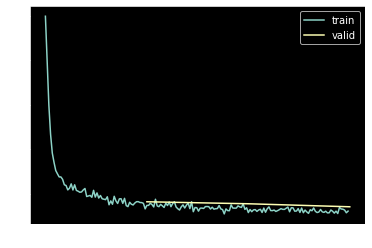

In [ ]:
learn.fit(3)

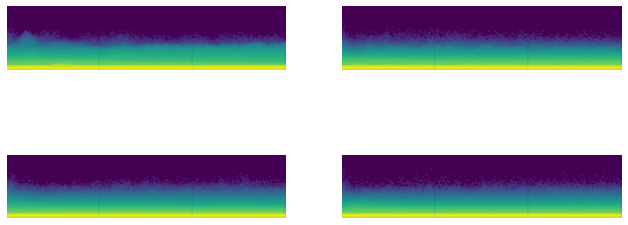

In [ ]:
# check color dims
astats.color_dim()

### RMSProp

Similar idea is RMSProp, which incldes in the update step the squared gradients. If squared gradients are large, this means that there is high volatility and our gradients are all over the place. In such case we don't want to make a large update to the parameter. During update we divide by the square root of squared gradients

In [ ]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        # super init + new variables
     
        
    def opt_step(self, p):
        # we initialize the first p.sqr_avg to the squared grad itself and not zero
        # because zero will lead to dividing by very small number(epsilon)
        
        # calculate moving squared grad_avg
      
        # perform the update
        

Generally we have to decrease the LR because we might be dividing by a small number

accuracy,loss,epoch,train
0.762,0.690,0,train
0.820,0.482,0,eval
0.853,0.397,1,train
0.851,0.415,1,eval
0.867,0.357,2,train
0.854,0.397,2,eval


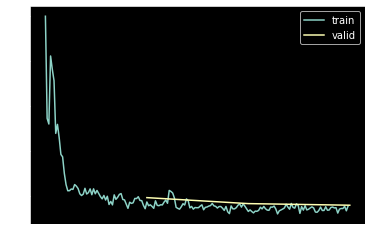

In [ ]:
set_seed(42)
# get model
model = 
# Train Learner with lr = 1e-2 and opt_func RMSProp
learn = 

learn.fit(3)

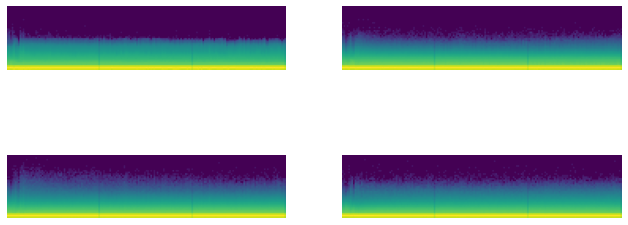

In [ ]:
# check color dim
astats.color_dim()

### Adam

RMSProp + Momentum = Adam

In [ ]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        # super + new parameters
       
        
    def opt_step(self, p):
        # if no `avg` attribute, create it with zeros
      
        # here we don't use trick with initializing to initial values of grads squared
        # but we will unbias avg and sqr_avg below
        # if no `sqr_avg` attribute, create it with zeros
       
        # calculate avg
       
        # unbias_avg
       
        # calculate sqr_avg
        
        # unbias_sqr_avg
       
        # update parameters
       

In [ ]:
avg = 0.4*0 + 0.6*1
print(avg); print(avg/(1-0.4))

0.6
1.0


In [ ]:
0.4*1 + 0.6*1

1.0

$avg = a * 0 + (1-a) * b$ <br>
$avg = (1-a)*b$

if distribution was equal: $avg = a*b + (1-a)*b = a*b +b -a*b = b $ so we divide by $(1-a)$ For further steps we exponentiate it to the `step`

accuracy,loss,epoch,train
0.760,0.684,0,train
0.826,0.470,0,eval
0.857,0.399,1,train
0.851,0.401,1,eval
0.875,0.344,2,train
0.863,0.370,2,eval


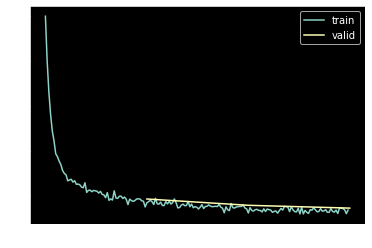

In [ ]:
set_seed(42)
model = 
# lr = 3e-3, opt_func = Adam
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or Learner, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [ ]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [ ]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

Pytorch schedulers work with pytorch optimizers. We can grab a pytorch optimizer using our TrainLearner and a SingleBatch callback to initialize the optimizer.

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

Let's look what methods pytorch optimizer has.

In [ ]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0] != '_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

pytorch optmizer spits parameters into groups that can have different learning rates and othe hyperparameters. Note that we can index into optimizer state dict wit tensor (parameter). In miniai we stored state inside parameters using attributes, pytorch stores state in separate state dict.

In [ ]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
opt.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[ 0.15, -0.19,  0.08],
                       [-0.01, -0.06,  0.26],
                       [ 0.16, -0.30,  0.23]]],
             
             
                     [[[ 0.05,  0.14,  0.03],
                       [ 0.33,  0.18, -0.04],
                       [-0.31,  0.18, -0.31]]],
             
             
                     [[[ 0.18,  0.06,  0.13],
                       [ 0.10, -0.25, -0.14],
                       [-0.07, -0.31,  0.22]]],
             
             
                     [[[-0.16, -0.16, -0.12],
                       [ 0.18, -0.00,  0.15],
                       [ 0.17, -0.01,  0.27]]],
             
             
                     [[[ 0.16,  0.19,  0.33],
                       [ 0.13,  0.27,  0.18],
                       [-0.14,  0.01, -0.17]]],
             
             
                     [[[ 0.26,  0.10, -0.23],
                       [ 0.30,  0.19,  0.02],
               

In [ ]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [ ]:
st

{'momentum_buffer': None}

In [ ]:
len(opt.param_groups)

1

In [ ]:
pg = opt.param_groups[0]
# quick way to get all the keys of a dict
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

In [ ]:
# we need to provide max number of steps. so it is `bs * epochs` for batch step 
# and epoch for epoch step 
# this is needed because scheduler will use a half-wave of a cosine
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [ ]:
sched.base_lrs

[0.006]

In [ ]:
sched.get_last_lr()

[0.006]

Let's create a simple plotting function to step optimizer, scheduler and plot scheduler learning rates

In [ ]:
def sched_lrs(sched, steps):
    # get last lr and store it in `lrs`
   
    # for each step
   
        # step optimizer
        # step scheduler
        # append new lr to lrs
       
    # plot
 

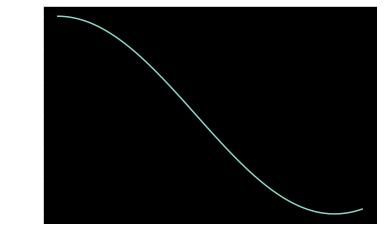

In [ ]:
sched_lrs(sched, 110)

## Scheduler callbacks

Create some scheduler callbacks

In [ ]:
#| export
class BaseSchedCB(Callback):
    def __init__(self, sched: Callable): 
    def before_fit(self, learn): 
        # create schedo - scehduler object
        
    def _step(self, learn):
        # step with a scheduler if training
       

In [ ]:
#| export
class BatchSchedCB(BaseSchedCB):
    # call _step after batch
   

To keep track of what is going on we create a Recorder Callback

In [ ]:
#| export
class RecorderCB(Callback):
    def __init__(self, **d): 
    
    def before_fit(self, learn):
        # create `self.recs` - a dict of names (of stuff to track) and resulting lists
       
        # grab the first parameter group (`self.pg`) to track
       
    
    def after_batch(self, learn): 
        # is not training - return
     
        # self.d strores names and functions (to grab relevant stuff) 
        # the function will take a cb as input and index into cb.pg to grab what it needs
       
    
    def plot(self):
        # plot keys and values in self.recs. Add legend and show
     

In [ ]:
a = RecorderCB(a=1,b=2)
a.d

{'a': 1, 'b': 2}

In [ ]:
def _lr(cb): return cb.pg['lr']

In [ ]:
len(dls.train)

59

In [ ]:
tmax = 3 * len(dls.train)
# use partial to pass tmax to CosineAnnealingLR
sched = 

Now let's train a model and record its learing rate

accuracy,loss,epoch,train
0.810,0.517,0,train
0.847,0.412,0,eval
0.881,0.323,1,train
0.878,0.329,1,eval
0.898,0.276,2,train
0.881,0.319,2,eval


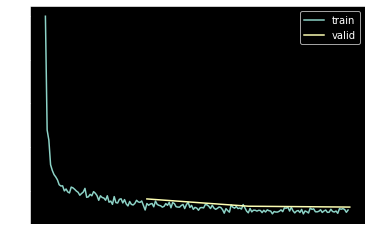

In [ ]:
set_seed(42)
model = 
# _lr recorder
rec = 
# BatchSchedCB and rec
xtra = 
# learner, lr=2e-2
learn = 

learn.fit(3)

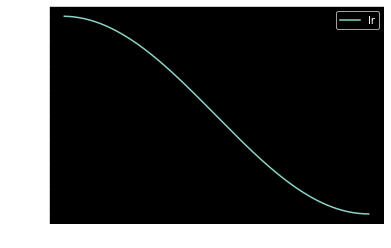

In [ ]:
rec.plot()

In [ ]:
#| export 
class EpochSchedStep(BaseSchedCB):
    # sched step after epoch
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.810,0.517,0,train
0.857,0.387,0,eval
0.882,0.321,1,train
0.874,0.335,1,eval
0.900,0.269,2,train
0.886,0.308,2,eval


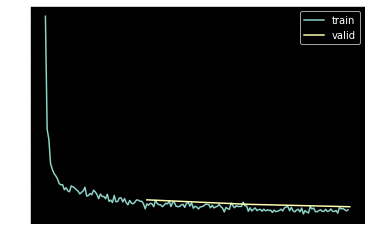

In [ ]:
# CosineAnnealingLR scheduler with step 3
sched = 
set_seed(42)
model =
rec =
xtra = 
learn = 
learn.fit(3)

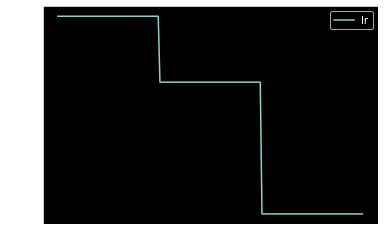

In [ ]:
rec.plot()

## 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [ ]:
# function to grab momentum (beta1) from callback using parameter groups
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.769,0.655,0,train
0.836,0.495,0,eval
0.861,0.377,1,train
0.855,0.404,1,eval
0.885,0.306,2,train
0.878,0.331,2,eval
0.908,0.247,3,train
0.899,0.281,3,eval
0.924,0.210,4,train
0.902,0.267,4,eval


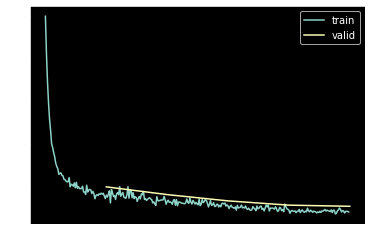

In [ ]:
set_seed(42)
lr, epochs = 6e-2, 5
model = 
tmax =
# OneCycleLR scheduler
sched = 
xtra = 
learn = 
learn.fit(epochs)

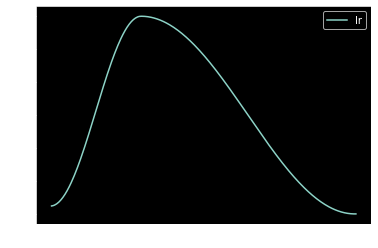

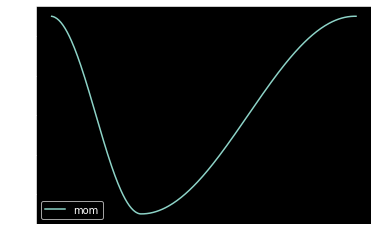

In [ ]:
rec.plot()

We see that learning rate starts low and then gets high, while momentum starts high and then gets low.

In [ ]:
import nbdev; nbdev.nbdev_export()

/root/.local/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/notebooks/fastai-p2/nbs/13_resnet.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
